In [8]:
from packaging import version

import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import tensorflow as tf
import os

2024-06-01 10:11:05.897287: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-01 10:11:05.921707: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-01 10:11:06.292469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Loading training metrics

In [9]:
def parse_tensorboard_log(path: str) -> dict:
    metrics = {}

    for event in tf.compat.v1.train.summary_iterator(path):
        if len(event.summary.value) == 0:
            continue

        metric_name = event.summary.value[0].tag
        metric_value = event.summary.value[0].simple_value
        timestamp = event.wall_time

        if metric_name in metrics:
            metrics[metric_name]['ts'].append(timestamp)
            metrics[metric_name]['value'].append(metric_value)
        else:
            metrics[metric_name] = {}
            metrics[metric_name]['ts'] = [timestamp]
            metrics[metric_name]['value'] = [metric_value]

    for name in metrics:
        metrics[name]['epoch'] = [i for i in range(len(metrics[name]['ts']))]

    return metrics

def load_metrics(path: str = "../runs"):

    model_metrics = {}

    for model_name in os.listdir(path):
        model_path = os.path.join(path, model_name)
        tensorboard_log_path = [
            os.path.join(model_path, f) for f in os.listdir(model_path) if f.startswith('events.out.tfevents')
        ][0]

        model_metrics[model_name] = parse_tensorboard_log(tensorboard_log_path)

    return model_metrics

metrics = load_metrics()


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


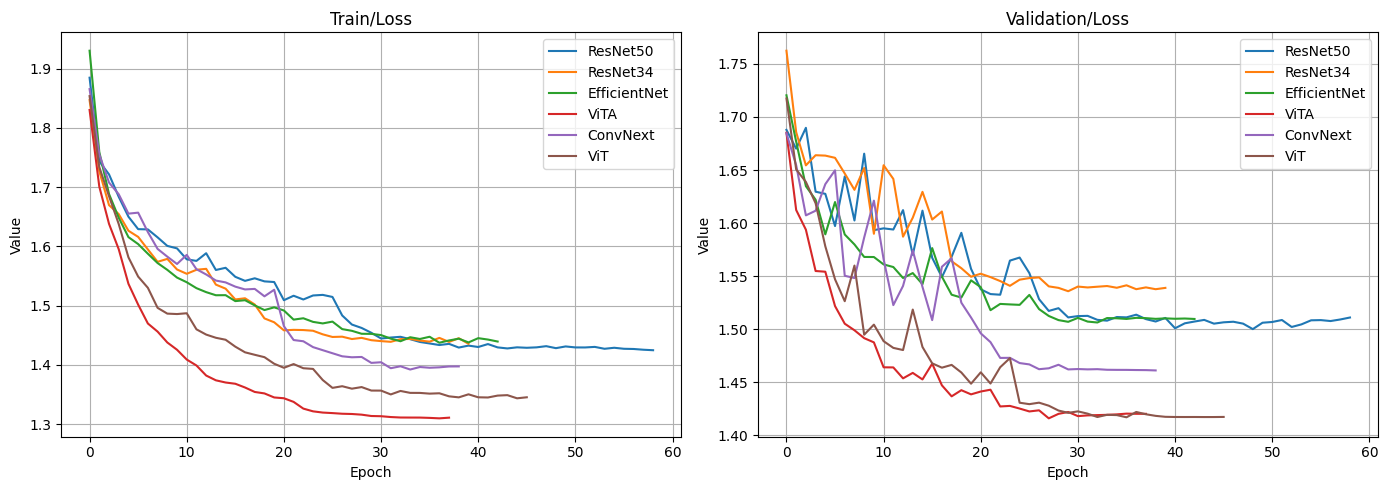

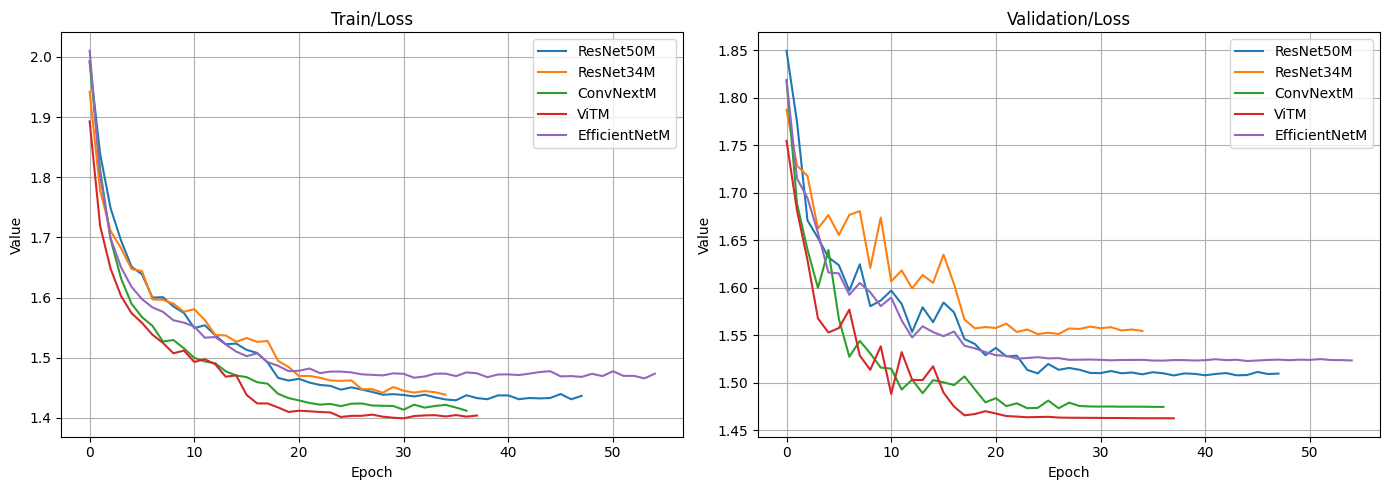

In [18]:
def plot_metrics(data, model_condition):
    """Plots specified metrics for models based on the given condition."""
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Filter models based on condition
    filtered_data = {k: v for k, v in data.items() if model_condition(k)}

    for i, metric in enumerate(['Train/Loss', 'Validation/Loss']):
        for model, model_metrics in filtered_data.items():
            if metric in model_metrics:
                axs[i].plot(model_metrics[metric]['epoch'], model_metrics[metric]['value'], label=model)
        axs[i].set_title(metric)
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel('Value')
        axs[i].grid()
        axs[i].legend()

    plt.tight_layout()
    plt.show()


# Plot metrics for models that don't end with 'M'
plot_metrics(metrics, lambda model_name: not model_name.endswith('M'))

# Plot metrics for models that end with 'M'
plot_metrics(metrics, lambda model_name: model_name.endswith('M'))

## Count number of parameters per model

In [28]:
from utilities import get_model

for name in ['ConvNext', 'ViT', "ResNet34", 'ResNet50', 'EfficientNet']:
    model_path = os.path.join(f'../models/{name}.pth')
    model_m_path = os.path.join(f'../models/{name}M.pth')

    model = get_model(model_name=name.lower(), num_classes=8, use_metadata=False)
    print(f'{name}: {sum(p.numel() for p in model.parameters())}')

    model = get_model(model_name=name.lower(), num_classes=8, use_metadata=True)
    print(f'{name}M: {sum(p.numel() for p in model.parameters())}')

Creating ConvNext
ConvNext: 87574664
Creating ConvNext
ConvNextM: 87641928
Creating ViT
ViT: 85804808
Creating ViT
ViTM: 85857736
Creating ResNet (resnet34)
ResNet34: 21288776
Creating ResNet (resnet34)
ResNet34M: 21327368
Creating ResNet (resnet50)
ResNet50: 23524424
Creating ResNet (resnet50)
ResNet50M: 23649032
Creating EfficientNet
Loaded pretrained weights for efficientnet-b0
EfficientNet: 4017796
Creating EfficientNet
Loaded pretrained weights for efficientnet-b0
EfficientNetM: 4099396
